In [109]:
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [110]:
import importlib
import gp
importlib.reload(gp)


<module 'gp' from 'c:\\Users\\Yue\\userDoc\\7 code\\Python\\advml\\project\\gp.py'>

**Dataset characteristics**<br>
- instant: record index<br>
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month (1 to 12)
- hr : hour (0 to 23)
- holiday : whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [111]:
import pandas as pd

df = pd.read_csv("hour.csv")
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


# Data

In [112]:
reference_date = pd.Timestamp('2011-01-01')
df.iloc[:, 1] = (pd.to_datetime(df.iloc[:, 1]) - reference_date).dt.days
data = df.to_numpy(dtype=float)
data

array([[1.0000e+00, 0.0000e+00, 1.0000e+00, ..., 3.0000e+00, 1.3000e+01,
        1.6000e+01],
       [2.0000e+00, 0.0000e+00, 1.0000e+00, ..., 8.0000e+00, 3.2000e+01,
        4.0000e+01],
       [3.0000e+00, 0.0000e+00, 1.0000e+00, ..., 5.0000e+00, 2.7000e+01,
        3.2000e+01],
       ...,
       [1.7377e+04, 7.3000e+02, 1.0000e+00, ..., 7.0000e+00, 8.3000e+01,
        9.0000e+01],
       [1.7378e+04, 7.3000e+02, 1.0000e+00, ..., 1.3000e+01, 4.8000e+01,
        6.1000e+01],
       [1.7379e+04, 7.3000e+02, 1.0000e+00, ..., 1.2000e+01, 3.7000e+01,
        4.9000e+01]])

In [113]:
X_raw = data[:, 1:14] # the first column is index, not necessary
X_mean = np.mean(X_raw, axis=0)
X_std = np.std(X_raw, axis=0)
X_whole = (X_raw - X_mean) / X_std # standardize X
Y_whole = data[:, 16]

In [114]:
def split_train_test(X_whole, Y_whole, num=1500, rate=0.7):
    X = X_whole[:num]
    Y = Y_whole[:num]

    # indices = np.random.permutation(num)
    indices = jax.random.permutation(grab_prng(), num)
    
    # Compute the split index
    split_idx = int(num * rate)
    
    # Split indices into train and test
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Split data using the indices
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = split_train_test(X_whole, Y_whole, num=1500, rate=0.7)

In [ ]:
def split_sequence(X_train, Y_train, seq_len=8):
    n_samples = X_train.shape[0]
    indices = jax.random.permutation(grab_prng(), n_samples)
     # Shuffle the data
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]
    
    # Calculate the base size of each subset
    subset_size = n_samples // seq_len
    remainder = n_samples % seq_len
    
    # Initialize lists to hold the subsets
    X_seq = []
    Y_seq = []
    
    start_idx = 0
    for i in range(seq_len):
        # The first subset gets the remainder (extra) samples
        if i == 0:
            end_idx = start_idx + subset_size + remainder
        else:
            end_idx = start_idx + subset_size
        
        X_seq.append(X_train_shuffled[start_idx:end_idx])
        Y_seq.append(Y_train_shuffled[start_idx:end_idx])
        
        start_idx = end_idx
    return X_seq, Y_seq

In [204]:
X_seq, Y_seq = split_sequence(X_train, Y_train, seq_len=8)
X_seq

[Array([[-1.69076676, -1.3566343 , -1.0051343 , ..., -1.62224482,
          1.20654153, -0.82148365],
        [-1.50035042, -1.3566343 , -1.0051343 , ..., -1.00541086,
         -1.07414596,  0.88609866],
        [-1.56699614, -1.3566343 , -1.0051343 , ..., -0.74063779,
         -0.29663886, -0.45609864],
        ...,
        [-1.67648553, -1.3566343 , -1.0051343 , ..., -1.62224482,
         -0.40030647,  0.27630622],
        [-1.58127736, -1.3566343 , -1.0051343 , ..., -1.44592342,
         -0.6076417 , -0.21169121],
        [-1.58603777, -1.3566343 , -1.0051343 , ..., -1.79856623,
         -1.17781357,  2.10650095]], dtype=float64),
 Array([[-1.50987124, -1.3566343 , -1.0051343 , ..., -0.38799498,
         -2.47365874,  1.13050609],
        [-1.55271491, -1.3566343 , -1.0051343 , ..., -1.71069649,
         -1.79981925, -0.45609864],
        [-1.48130879, -1.3566343 , -1.0051343 , ..., -0.12380383,
         -1.12597977,  5.03448556],
        ...,
        [-1.64792308, -1.3566343 , -1.0

In [7]:
# X_train = np.array(data)[0:13000,2:14]
# Y_train = np.array(data)[0:13000,16]
# X_test = np.array(data)[13000:,2:14]
# Y_test = np.array(data)[13000:,16]

X_train = np.array(data)[0:1300,2:14]
Y_train = np.array(data)[0:1300,16]
X_test = np.array(data)[1300:1700,2:14]
Y_test = np.array(data)[1300:1700,16]

In [8]:
# X_train = np.load('X_train.npy')
# Y_train = np.load('Y_train.npy')
# X_test = np.load('X_test.npy')
# Y_test = np.load('Y_test.npy')

In [9]:
type(X_train)

jaxlib.xla_extension.ArrayImpl

# Hyperparameter initialization

Note that, in the below initialization, it is assumed that noise variance is the first component, signal variance the second, and length scale the third. Feel free to modify if using pytrees.

Further note: these are assumed constrained (strictly positive). You should map to unconstrained prior to running optimization, and map back to constrained when forming the GP posterior, and evaluating the predictive density for evaluation.

In [10]:
def random_init_sqexp_hyperparams():
    return np.array([jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
                     jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
                     X_train.shape[1]*jax.random.uniform(grab_prng(), minval=1, maxval=10)])
#

# Plotting code

In [11]:
def scatterplot(lml_lpd):
    plt.scatter(lml_lpd[:,0], lml_lpd[:,1])
    
    plt.xlabel('Log marginal likelihood')
    plt.ylabel('Negative log predictive density')
    plt.title('Is marginal likelihood a good indicator of generalization?')
    plt.legend()
#

# Experiment 1: Empirical Bayes for squared-exponential kernel

In [12]:
n_trials = 50
T = 200
step_size = 5e-4

gathered_trials = []

cov_func = sqexp_cov_function
X_star = X_test
for n in range(n_trials):
   hyperparams_init = random_init_sqexp_hyperparams()
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   
   sqexp_cov_function(X_train, X_train, unconstrained_hyperparams_init)
   
   (unconstrained_hyperparams, val) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])

   gathered_trials.append(np.array([neg_log_initial, neg_log_final, val]))
#
gathered_trials

[Array([ 428451.12704844,   60099.4918022 , -194339.978264  ], dtype=float64),
 Array([1645485.09838026,              nan,              nan], dtype=float64),
 Array([ 652483.91784429,   99522.74822705, -322465.56164476], dtype=float64),
 Array([ 535060.86395776,   72435.92440368, -234433.38421879], dtype=float64),
 Array([233547.78600555,  25090.63138903, -80561.18192117], dtype=float64),
 Array([1401888.89871953,              nan,              nan], dtype=float64),
 Array([ 529789.70083504,   80328.06996564, -260082.85729516], dtype=float64),
 Array([ 486641.04569506,   54042.63500892, -174655.19368582], dtype=float64),
 Array([ 539729.96648047,   69944.68212258, -226336.84680521], dtype=float64),
 Array([ 526942.19720906,   78298.62455459, -253487.15970926], dtype=float64),
 Array([ 722531.05560154,  111919.96233866, -362756.50750747], dtype=float64),
 Array([ 298570.74411773,   39965.43052567, -128904.27911526], dtype=float64),
 Array([ 303982.80273059,   39956.47596594, -128875.176

C:\Users\Yue\AppData\Local\Temp\ipykernel_26392\1312685826.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


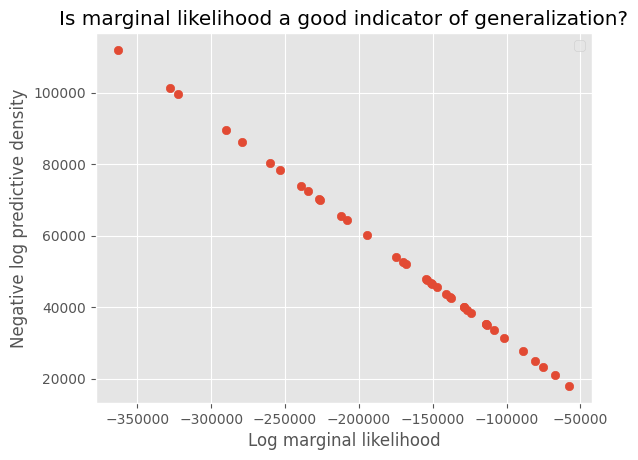

In [13]:
trials_array = np.array(gathered_trials)
lml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(lml_lpd)


# Dicsussion
1. Negative log probability was consistently improved over the hyperparameters used at initialization, across all runs.
2. According to the scatterplot above, we can see that as log marginal likelihood increases, negative log predicitive density on test set decreases at first, and increases later. Log marginal likelihood is a metric of our hyperparameters. The larger log marginal likelihood is, the better our hyperparameters are. But if they are better is determined by training set. Thus it's reasonable that "better" hyperparameters on training set don't always work better on test set. A large marginal likelihood may cause overfitting, although it works very well on training set. It's not a good indicator of generalization.

# Experiment 2 - feature importance using learned Mahalanobis distances

In [14]:
# use as your initial hyperparameters -> first two parameters are noise variance and signal variance,
# remaining parameters are length scale; feel free to modify if using pytrees
init_params = [1e0, 1e0] + [X_train.shape[1]*1e0 for _ in range(X_train.shape[1])]

In [15]:
T = 200
step_size = 5e-4
gathered_trials = []

cov_func = sqexp_mahalanobis_cov_function
X_star = X_test
for n in range(1):
   hyperparams_init = np.array(init_params)
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, val) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])

   gathered_trials.append(np.array([neg_log_initial, neg_log_final, val]))
#
gathered_trials

[Array([268926.15624536,  22090.77528547, -70811.64958463], dtype=float64)]

In [16]:
feature_name = ['Hour of day', 'Level of carbon monoxide', 'Level of non-methane hydrocarbons', 'Level of nitrogen oxides', 'Temperature', 'Relative humidity', 'Absolute humidity']
feature_val = hyperparams[2:]
print("\n".join(f"{name.ljust(35)}  {val:0.3f}" for name, val in zip(feature_name, feature_val)))

Hour of day                          12.000
Level of carbon monoxide             12.000
Level of non-methane hydrocarbons    0.470
Level of nitrogen oxides             0.000
Temperature                          6.633
Relative humidity                    17.558
Absolute humidity                    0.000


# Dicsussion
1. Negative log probability was consistently improved over the hyperparameters used at initialization.
2. Length scales are displayed above. Level of nitrogen oxides is the most important, while temperature is the least important.<br>For 1d case, $cov(x_i,x_j) \propto exp(-(x_i-x_j)^2/l)$. Thus the less $l$ is, the more sensitive the covariance function is to the difference between two inputs, meaning that this feature is more important. If $l$ is very large, the covariance function almost always keeps the same, meaning that this feature is not important at all.
3. Emperical bayes tends to reduce log marginal likelihood, which consists of two terms: one of them represents data fit, and the other represents simpler model. Smaller $l$ means better data fit, while larger $l$ means simpler model. Emperical bayes tends to reduce the importance of features, i.e., to increase $l$, so that the model is more general; but it also considers data fit, so it reduces the importance of features if possible.